# Violence Against Women

## Table of Contents
1. [Set Up](#Set_Up)
2. [Preprocessing](#Preprocessing)
    1. [Split Datasetd](#Split_Datasetd)
    2. [Remove Outliers](#Remove_Outliers)
    3. [Impute](#Impute)
    4. [Scale](#Scale)
    5. [P.C.A.](#PCA)
3. [Data Mining](#Data_Mining)
    1. [Logistic Regression](#Logistic_Regression)
    2. [k-Nearest Neighbors](#k_Nearest_Neighbors)
    3. [Disicion Tree](#Disicion_Tree)
    4. [Support Vector Machine](#Support_Vector_Machine)
    5. [Random Forest](#Random_Forest)
    6. [XGBoosting](#XGBoosting)
4. [Evaluation-Interpretation](#Evaluation_Interpretation)
5. [Prediction](#Prediction)
    1. [Merge All Three SubDatasets Back to One](#Merge_All_Three_SubDatasets_Back_to_One)
    2. [Save New Dataset as .csv](#Save_New_Dataset_as_.csv)

<a id="Set_Up"></a>
## Set_Up

In [1]:
# Imports
# Basics
import numpy as np
import pandas as pd


# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Cross validation
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn import metrics

from utils import OUTCOME_ENCODES

In [2]:
# Read Preprocessed Data from WAV_Preprocessed.csv file
data = pd.read_csv('datasets/WAV_Preprocessed.csv', 
                    # Specify the first row as the header
                    header=0
                    )

# Take a look to make sure the data are correctly loaded
data.head()

,Time,Outcome,Observation_Value,Age_15-49,Country_CK,Country_FJ,Country_FM,Country_KI,Country_MH,Country_NR,...,Prptr_FAMMAL,Prptr_NONPART,Prptr_OTHFEM,Prptr_OTHMAL,Prptr_PARTNER,Actual_ALO12M,Actual_ALOLIFE,L_Per_BEFORE15,L_Per_PREGNANCY,L_Per_SINCE15
0,2013,25,6.2,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2013,25,9.6,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,2013,25,26.7,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,2013,25,6.7,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,2013,25,30.2,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


<a id="Preprocessing"></a>
## Preprocessing

<a id="Split_Datasets"></a>
### Split Datasets

Splitting the dataset into training and testing sets before performing preprocessing transformations is important to ensure that the preprocessing steps are performed consistently on both the training and testing sets. This helps to prevent information leakage, where information from the testing set is used to inform the preprocessing steps and artificially inflates the model's performance. By splitting the dataset first, we can ensure that the preprocessing steps are only informed by the training set, giving us a more accurate evaluation of the model's performance on the testing set. Additionally, this helps to ensure that the preprocessing steps are generalizable and can be applied to new data.

In [3]:
RANDOM_SEED = 42

In [4]:
# Split the data into training and target sets
# The target set will be used to predict missing values of the Outcome feature
target_set = data.loc[data['Outcome'] == OUTCOME_ENCODES['ANY']]
train_set  = data.loc[data['Outcome'] != OUTCOME_ENCODES['ANY']]

# Create X_pred and y_pred as the predictors and target for the target set
X_pred = target_set.drop('Outcome', axis=1)
y_pred = target_set['Outcome']


# Create X and y as the predictors and target for the training set
X = train_set.drop('Outcome', axis=1)
y = train_set['Outcome']

# Split the training set into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15,
                                                    random_state=RANDOM_SEED,
                                                    stratify=y)

# Print the shape of each dataset
print('X_train: '  + str(X_train.shape))
print('y_train: '  + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('y_test:  '  + str(y_test.shape))
print('X_pred: '   + str(X_pred.shape))
print('y_pred: '   + str(y_pred.shape))

X_train: (462, 68)
y_train: (462,)
X_test:  (82, 68)
y_test:  (82,)
X_pred: (1472, 68)
y_pred: (1472,)


<a id="Remove_Outliers"></a>
### Remove Outliers

Removing outliers from the dataset is important to ensure that the machine learning models are trained on a representative sample of the data. Outliers can have a disproportionate impact on the model's performance and can skew the results. By removing outliers, we can ensure that the model is only trained on the most representative and relevant data, leading to improved accuracy and more robust results. Additionally, removing outliers can help to prevent overfitting, where the model is too heavily influenced by a small number of extreme points.

<AxesSubplot:xlabel='Observation_Value'>

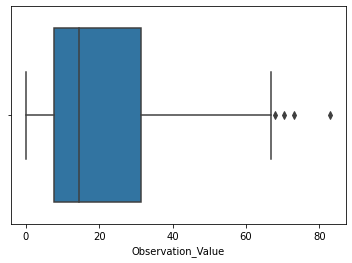

In [5]:
# Plotting boxplot of the 'Observation_Value' feature in the training set
sns.boxplot(x=X_train['Observation_Value'])

The boxplot shows the distribution of the 'Observation_Value' feature in the training set.
The box represents the interquartile range (IQR), which contains 50% of the data.
The line inside the box represents the median, and the whiskers extend to the minimum and maximum values within 1.5 times the IQR.
Any points outside of the whiskers are considered outliers and are plotted individually.
This plot can be used to identify outliers from the training set.

In [6]:
# Calculate interquartile range (IQR) and quartile 1 (Q1) and quartile 3 (Q3)
# values for the 'Observation_Value' feature in the training set
Q1 = X_train['Observation_Value'].quantile(0.25)
Q3 = X_train['Observation_Value'].quantile(0.75)
IQR = Q3 - Q1

# Print the calculated IQR, Q1, and Q3 values
print(f'Range: {IQR}')
print(f'Q1: {Q1}')
print(f'Q3: {Q3}')

Range: 23.849999999999998
Q1: 7.625
Q3: 31.474999999999998


The IQR value represents the spread of the middle 50% of the data.
The Q1 value is the first quartile, or 25th percentile, and Q3 is the third quartile, or 75th percentile.
These values can be used to identify and remove outliers from the dataset.

In [7]:
# Calculate lower and upper bounds for identifying outliers using the IQR value
lower_bound = Q1 - (1.5 * IQR) 
upper_bound = Q3 + (1.5 * IQR)

# Print the calculated lower and upper bounds
# Values outside this range are considered outliers
print(f'Bounds: [{lower_bound},{upper_bound}]')
print(f'Bounds Range: {upper_bound-lower_bound}')

Bounds: [-28.15,67.25]
Bounds Range: 95.4


In [8]:
# Identify the outliers by finding the rows whose Observation_Value is below lower_bound or above upper_bound
outliers_rows = (X_train['Observation_Value'].index[(X_train['Observation_Value'] < lower_bound) |(X_train['Observation_Value'] > upper_bound)]).tolist()

# Print the number of outliers and the index of the rows with outliers
print(f'There are {len(outliers_rows)} outliers:')
print(outliers_rows)

There are 4 outliers:
[1344, 1720, 1089, 1866]


In [9]:
# Remove the rows containing outliers in the training set
X_train = X_train.drop(outliers_rows, axis=0)
y_train = y_train.drop(outliers_rows, axis=0)

# Check if number of rows in X_train and y_train are equal after removing outliers
print(X_train.shape[0] == y_train.shape[0])

# Print the number of rows remaining in the training set
print(X_train.shape[0])

True
458


<a id="Impute"></a>
### Impute

Imputing is necessary before training because it replaces missing values in the data with estimated values based on the other available information in the data. This helps to ensure that the model has a complete and accurate representation of the data to work with, reducing the risk of missing data impacting the model's performance.

In [10]:
# Using IterativeImputer to impute missing values in the datasets.
# Setting the maximum number of iteration to 10 and random state to RANDOM_SEED for reproducibility.
imp = IterativeImputer(max_iter=10, random_state=RANDOM_SEED)

# Fit and transform the imputer on X_train dataset
imputed_array = imp.fit_transform(X_train)

# Convert the imputed array back to a dataframe with the same index and columns as the original X_train
X_train = pd.DataFrame(imputed_array, index=X_train.index, columns=X_train.columns)

# Impute missing values in X_test using the imputer fit on X_train
imputed_array = imp.transform(X_test)
# Convert the imputed array back to a dataframe with the same index and columns as the original X_test
X_test = pd.DataFrame(imputed_array, index=X_test.index, columns=X_test.columns)

# Impute missing values in X_pred using the imputer fit on X_train
imputed_array = imp.transform(X_pred)
# Convert the imputed array back to a dataframe with the same index and columns as the original X_pred
X_pred = pd.DataFrame(imputed_array, index=X_pred.index, columns=X_pred.columns)

<a id="Scale"></a>
### Scale 

Scaling is necessary before training a machine learning model to ensure that all features have similar magnitude. This helps to avoid biased results due to the differences in scale between features and can improve model performance. Scaling also helps in better visualization of the data and better optimization in certain algorithms.

In [11]:
#MinMaxScaler for normalizing the data in range of 0 to 1
scaler = MinMaxScaler()

# Scaling the training set
scaled_array = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_array, index=X_train.index, columns=X_train.columns)

# Scaling the testing set
scaled_array = scaler.transform(X_test)
X_test = pd.DataFrame(scaled_array, index=X_test.index, columns=X_test.columns)

# Scaling the prediction set
scaled_array = scaler.transform(X_pred)
X_pred = pd.DataFrame(scaled_array, index=X_pred.index, columns=X_pred.columns)

<a id="PCA"></a>
### P.C.A. (Principal Component Analysis)

PCA, or Principal Component Analysis, is a dimensionality reduction technique that is applied before training to reduce the number of features in the data. This can improve the training time, reduce overfitting, and help capture the most important patterns in the data. By transforming the data into a new space with fewer dimensions, PCA can help simplify the data and make it easier for the machine learning model to understand the relationships between the features.

In [12]:
# Fit PCA to the training data
pca = PCA(random_state=RANDOM_SEED)
pca = pca.fit(X_train)

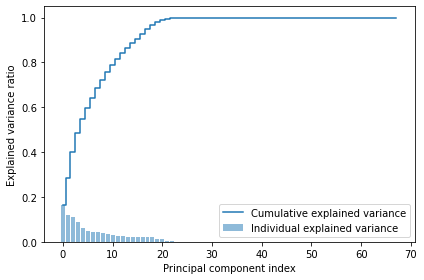

In [13]:
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [14]:
# Sum up the explained variance of each principal component
total_var = 0

# Loop through each explained variance
for i, var in enumerate(exp_var_pca):
    # Add the explained variance to the total
    total_var += var

    # If the cumulative sum of explained variance is greater than .99, print the number of components needed
    # to retain 99% of information
    if total_var > .99:
        print(f'For {i+1} components there is over 99% of information kept!')
        break

For 22 components there is over 99% of information kept!


In [15]:
# Perform PCA
# The random_state is set to ensure the results are consistent across multiple runs
pca = PCA(n_components=21, random_state=RANDOM_SEED)

# Fit the PCA model on the training data and transform it into PCA components
pca_array = pca.fit_transform(X_train)
X_train = pd.DataFrame(pca_array, index=X_train.index)

# Transform the test set into PCA components
pca_array = pca.transform(X_test)
X_test = pd.DataFrame(pca_array, index=X_test.index)

# Transform the predict set into PCA components
pca_array = pca.transform(X_pred)
X_pred = pd.DataFrame(pca_array, index=X_pred.index)

<a id="Data_Mining"></a>
## Data Mining

<a id="Logistic_Regression"></a>
### Logistic Regression

Logistic Regression is a statistical method for analyzing a dataset in which there are one or more independent variables that determine an outcome. It is used to model the probability of a certain class or event existing such as yes or no, true or false, 1 or 0, etc. It is commonly used in binary classification problems and also can be extended to multiclass problems through the use of one-vs-all or softmax functions.

In [16]:
%%time

import warnings
warnings.filterwarnings('ignore')

# Define the Logistic Regression model
logisticRegressor = LogisticRegression(multi_class='multinomial', 
                                       random_state=RANDOM_SEED,  # set the random seed for reproducibility
                                       class_weight='balanced'    # set class weight to balanced to deal with class imbalance
                                       )   

# Define model parameters for the grid search
param_grid = {'penalty':['l1', 'l2'],
              'C': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}

# Define the (10-Fold) Cross Validation Grid Search using f1_macro as the evaluation metric
search = GridSearchCV(estimator=logisticRegressor,
                      param_grid=param_grid,
                      scoring='f1_macro',
                      cv=10)

# Fit the model to the training data
search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print(search.best_params_)
# Print the best score achieved during the grid search
print(search.best_score_)

# Re-assign logisticRegressor to the best estimator from the grid search
logisticRegressor = search.best_estimator_

{'C': 0.4, 'penalty': 'l2'}
0.12006049506049507
CPU times: total: 8.12 s
Wall time: 816 ms


<a id="K_Nearest_Neighbors"></a>
### K-Nearest Neighbors

K-Nearest Neighbors (KNN) is a supervised machine learning algorithm used for both classification and regression. The idea behind KNN is to find the K nearest data points in the training set for a given test data point and make a prediction based on the class or numeric value of the majority of these neighbors.

In [17]:
%%time

import warnings
warnings.filterwarnings('ignore')

# Define the K-Neighbors Classifier model using the minkowski metric
kNearestNeighbors = KNeighborsClassifier(metric='minkowski')

# Define model parameters for the grid search
param_grid = {'n_neighbors':list(range(5,35)), # sqrt(435)~20 => [20-15,20+15] = [5,35]
              'weights':['distance','uniform'],
              'p':[1,2,3,4,5,6,7,8,9,10]}

# Define the (10-Fold) Cross Validation Grid Search using f1_macro as the evaluation metric
search = GridSearchCV(estimator=kNearestNeighbors,
                      param_grid=param_grid,
                      scoring='f1_macro',
                      cv=10)

# Fit the model to the training data
search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print(search.best_params_)
# Print the best score achieved during the grid search
print(search.best_score_)

# Re-assign kNearestNeighbors to the best estimator from the grid search
kNearestNeighbors = search.best_estimator_

{'n_neighbors': 33, 'p': 2, 'weights': 'uniform'}
0.1344502235982112
CPU times: total: 2min 22s
Wall time: 1min 9s


<a id="Disicion_Tree"></a>
### Disicion Tree

A decision tree is a tree-like model used in decision analysis and decision-making that splits data into branches based on conditions or rules, ultimately resulting in a prediction or decision. Each internal node of the tree represents a "test" on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes).

In [18]:
%%time

import warnings
warnings.filterwarnings('ignore')

# Define the Decision Tree Classifier model
decisionTree = DecisionTreeClassifier(random_state=RANDOM_SEED, # set the random seed for reproducibility
                                      class_weight='balanced')  # set class weight to balanced to deal with class imbalance

# Define model parameters for the grid search
param_grid = {'criterion':['gini','entropy'],
              'splitter':['best','random'],
              'max_depth':[2,3,4,5,6,7,8],
              'min_samples_split':[2,3,4],
              'min_samples_leaf':[2,3,4,5,6]}

# Define the (10-Fold) Cross Validation Grid Search using f1_macro as the evaluation metric
search = GridSearchCV(estimator=decisionTree,
                      param_grid=param_grid,
                      scoring='f1_macro',
                      cv=10)

# Fit the model to the training data
search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print(search.best_params_)
# Print the best score achieved during the grid search
print(search.best_score_)

# Re-assign decisionTree to the best estimator from the grid search
decisionTree = search.best_estimator_

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'random'}
0.16102456432456433
CPU times: total: 23.2 s
Wall time: 23.1 s


<a id="Support_Vector_Machine"></a>
### Support Vector Machine

Support Vector Machines (SVM) is a type of supervised learning algorithm used for classification and regression analysis. The SVM algorithm finds a boundary that separates the data into classes by maximizing the margin, i.e., the distance between the closest data points from each class, known as support vectors.

In [19]:
%%time

# Define the Support Vector Machine Classifier model
supportVectorMachine = SVC(random_state=RANDOM_SEED, # set the random seed for reproducibility
                           class_weight='balanced')  # set class weight to balanced to deal with class imbalance

# Define model parameters for the grid search
param_grid = [{'kernel':['linear'],
               'C':[0.125, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]},
              {'kernel':['poly'],
               'degree':[2,3,4,5,6,7,8],
               'coef0':[0,1],
               'gamma':[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.5, 1, 2, 4],
               'C':[0.125, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]},
              {'kernel':['rbf'],
               'gamma':[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.5, 1, 2, 4],
               'C':[0.125, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]},
              {'kernel':['sigmoid'],
               'coef0':[0,1],
               'gamma':[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.5, 1, 2, 4],
               'C':[0.125, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]}]

# Define the (10-Fold) Cross Validation Grid Search using f1_macro as the evaluation metric
search = GridSearchCV(estimator=supportVectorMachine,
                      param_grid=param_grid,
                      scoring='f1_macro',
                      cv=10)

# Fit the model to the training data
search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print(search.best_params_)
# Print the best score achieved during the grid search
print(search.best_score_)

# Re-assign supportVectorMachine to the best estimator from the grid search
supportVectorMachine = search.best_estimator_

{'C': 128, 'coef0': 0, 'gamma': 0.5, 'kernel': 'sigmoid'}
0.1795047619047619
CPU times: total: 7min 25s
Wall time: 7min 25s


<a id="Random_Forest"></a>
### Random Forest

Random Forest is an ensemble learning method for classification and regression that operates by constructing a multitude of decision trees and aggregating their predictions. It uses bootstrapped samples of the input data and a random subset of the features at each split of each decision tree to reduce overfitting and increase model accuracy.

In [20]:
%%time

# Define the Random Forest Classifier model
randomForest = RandomForestClassifier(random_state=RANDOM_SEED, # set the random seed for reproducibility
                                      class_weight='balanced')  # set class weight to balanced to deal with class imbalance

# Define model parameters for the grid search
param_grid = {'n_estimators':[5,10,15,20,25,30,35,40],
              'criterion':['gini','entropy'],
              'max_depth':[3,4,5,6,7,8],
              'min_samples_split':[2,3,4,5],
              'min_samples_leaf':[1,2,3]}

# Define the (10-Fold) Cross Validation Grid Search using f1_macro as the evaluation metric
search = GridSearchCV(estimator=randomForest,
                      param_grid=param_grid,
                      scoring='f1_macro',
                      cv=10)

# Fit the model to the training data
search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print(search.best_params_)
# Print the best score achieved during the grid search
print(search.best_score_)

# Re-assign randomForest to the best estimator from the grid search
randomForest = search.best_estimator_

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
0.16004679764679766
CPU times: total: 7min 49s
Wall time: 7min 49s


<a id="XGBoosting"></a>
### XGBoosting

XGBoost (eXtreme Gradient Boosting) is an optimized and scalable gradient boosting library designed for high-performance machine learning. It is an efficient and effective implementation of the gradient boosting algorithm, combining speed, memory efficiency, and a high level of parallelism to achieve improved accuracy and performance on a variety of machine learning tasks.

In [21]:
%%time

import warnings
warnings.filterwarnings('ignore')

# Define the XGBoost Classifier model
xGBoost = XGBClassifier(random_state=RANDOM_SEED, # set the random seed for reproducibility
                        class_weight='balanced')  # set class weight to balanced to deal with class imbalance

# Define model parameters for the grid search
param_grid = {'n_estimators':[125,130,135,140,145,150,155]}

# Define the (10-Fold) Cross Validation Grid Search using f1_macro as the evaluation metric
search = GridSearchCV(estimator=xGBoost,
                      param_grid=param_grid,
                      scoring='f1_macro',
                      cv=10)

# Fit the model to the training data
search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print(search.best_params_)
# Print the best score achieved during the grid search
print(search.best_score_)

# Re-assign xGBoost to the best estimator from the grid search
xGBoost = search.best_estimator_

[19:51:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:51:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:51:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:51:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:51:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are n

<a id="Evaluation_Interpretation"></a>
## Evaluation Interpretation

In [22]:
def evaluation_func(model, X_train, X_test, y_train, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Use the model to make predictions on the test data
    y_hat = model.predict(X_test)
    
    # Calculate the accuracy of the model's predictions
    accuracy = metrics.accuracy_score(y_test,y_hat)
    # Calculate the precision of the model's predictions
    precision = metrics.precision_score(y_test,y_hat,average='macro')
    # Calculate the recall of the model's predictions
    recall = metrics.recall_score(y_test,y_hat,average='macro')
    # Calculate the F1 score of the model's predictions
    f1 = metrics.f1_score(y_test,y_hat,average='macro')
    
    # Return a list of evaluation metrics
    return [accuracy,precision,recall,f1]

In [23]:
import warnings
warnings.filterwarnings('ignore')

# Lists of models to evaluate
models = [logisticRegressor,
          kNearestNeighbors,
          decisionTree,
          supportVectorMachine,
          randomForest,
          xGBoost]

# Lists to store evaluation metrics for each model
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through each model in the list
for model in models:
    # Use the evaluation function to calculate scores
    [acc,pre,rec,f1] = evaluation_func(model, X_train, X_test, y_train, y_test)
    # Append the scores to the corresponding lists
    accuracy_scores.append(acc)
    precision_scores.append(pre)
    recall_scores.append(rec)
    f1_scores.append(f1)

[19:52:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



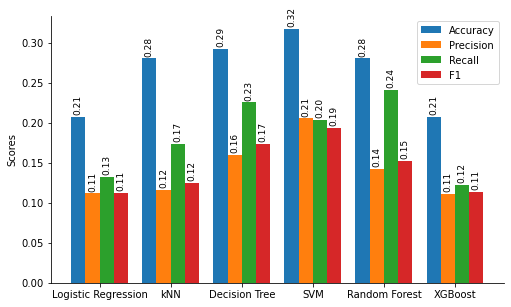

In [35]:
# Labels for each model
labels = ['Logistic Regression', 'kNN', 'Decision Tree', 'SVM', 'Random Forest', 'XGBoost']
# Locations for each label
x = np.arange(len(labels))*2.5
# Width of each bar
width = 0.50

# Initialize plot and axes
fig, ax = plt.subplots()

# Create grouped bar chart
rects1 = ax.bar(x - 0.75, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x - 0.25, precision_scores, width, label='Precision')
rects3 = ax.bar(x + 0.25, recall_scores, width, label='Recall')
rects4 = ax.bar(x + 0.75, f1_scores, width, label='F1')

# Add label to y-axis
ax.set_ylabel('Scores')
# Add x-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(labels)
# Add legend
ax.legend()

# Add value labels to each bar
ax.bar_label(rects1, fmt='%.2f', fontsize=9, rotation=90, padding=2)
ax.bar_label(rects2, fmt='%.2f', fontsize=9, rotation=90, padding=2)
ax.bar_label(rects3, fmt='%.2f', fontsize=9, rotation=90, padding=2)
ax.bar_label(rects4, fmt='%.2f', fontsize=9, rotation=90, padding=2)

# Adjust plot layout
fig.tight_layout(rect=(0,0,1.2,1.1))

# Remove spines
sns.despine()

# Show plot
plt.show()

<a id="Prediction"></a>
## Prediction

Given the results, it can be seen that the Support Vector Machine model performed the best, thus it will be utilized to predict the missing values for the target feature (ANY).

In [36]:
supportVectorMachine.fit(X_train, y_train)

y_hat = model.predict(X_pred)
y_hat = pd.Series(y_hat, name='Outcome', index=X_pred.index) # Convert to pd.Series with correct index

### Merge_All_Three_SubDatasets_Back_to_One

In [248]:
# Concat horisontaly
vaw_train = pd.concat([X_train, y_train], axis=1)
vaw_test = pd.concat([X_test, y_test], axis=1)
vaw_pred = pd.concat([X_pred, y_hat], axis=1)

# Shape of dataset
print('vaw_train: ' + str(vaw_train.shape))
print('vaw_test: ' + str(vaw_test.shape))
print('vaw_pred:  '  + str(vaw_pred.shape))

vaw_train: (429, 22)
vaw_test: (109, 22)
vaw_pred:  (1472, 22)


In [249]:
# Concat with respect to index (verticaly)
vaw_v4 = pd.concat([vaw_train, vaw_test, vaw_pred], axis=0).sort_index()

# Change the col names (P.Comp = Principal Component)
column_names = []

for i in range(21):
    column_names.append(f'P.Comp_{(i+1):02d}')
    
column_names.append('Outcome')
vaw_v4.columns = column_names
# Final Dataset
vaw_v4.head()

,P.Comp_01,P.Comp_02,P.Comp_03,P.Comp_04,P.Comp_05,P.Comp_06,P.Comp_07,P.Comp_08,P.Comp_09,P.Comp_10,P.Comp_11,P.Comp_12,P.Comp_13,P.Comp_14,P.Comp_15,P.Comp_16,P.Comp_17,P.Comp_18,P.Comp_19,P.Comp_20,P.Comp_21,Outcome
0,-0.095146,-0.270775,-0.160796,0.056499,0.263191,0.094090,0.193086,0.202750,0.450894,-0.162408,-0.019386,-0.189745,0.203501,-0.014376,0.328980,0.594006,-0.500987,0.458466,-0.144457,0.144544,-0.133649,22
1,0.184818,-0.178934,-0.254737,0.034532,0.331010,0.116268,0.194603,-0.474799,0.634516,-0.238699,0.059973,-0.154528,0.179162,-0.017794,0.309899,0.595497,-0.511303,0.511923,-0.148456,0.084257,-0.133387,22
2,0.237574,-0.115207,-0.200532,-0.011499,0.130076,-0.009226,0.228233,0.881630,0.304834,-0.129532,0.102924,-0.195364,0.180656,-0.004536,0.356172,0.546696,-0.459488,0.420419,-0.159465,0.086078,-0.159865,14
3,0.285659,-0.150339,-0.289820,0.029470,0.353184,0.111596,0.173367,-0.434884,0.688644,-0.191000,0.428473,-0.128052,0.172569,-0.030816,0.113693,0.345776,-0.362756,1.135812,-0.271234,0.084436,-0.036880,9
4,0.345141,-0.075935,-0.225586,-0.029478,0.132346,-0.027542,0.216382,0.928776,0.366435,-0.107082,0.489098,-0.160765,0.157516,-0.016043,0.160051,0.284551,-0.303923,1.043480,-0.284147,0.077171,-0.083043,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,-0.049534,0.163366,0.560462,0.155557,0.536468,0.171218,-0.005066,-0.043865,-0.171883,0.555886,0.059725,0.391102,-0.119554,-0.015795,0.044403,-0.442672,-0.457955,-0.061588,0.066864,0.179926,-0.149922,23
2012,-0.060819,0.145451,0.543632,0.177232,0.569866,0.194113,-0.020814,-0.056000,-0.184423,0.598255,0.030067,0.377471,-0.091788,-0.018338,0.044259,-0.421826,-0.469732,-0.060198,0.070058,0.195173,-0.116890,23
2013,-0.054619,0.155293,0.552878,0.165324,0.551518,0.181535,-0.012163,-0.049333,-0.177534,0.574979,0.046361,0.384960,-0.107042,-0.016941,0.044338,-0.433278,-0.463262,-0.060962,0.068303,0.186797,-0.135037,23
2014,-0.064917,0.138945,0.537521,0.185104,0.581995,0.202427,-0.026533,-0.060406,-0.188976,0.613642,0.019297,0.372522,-0.081705,-0.019262,0.044207,-0.414255,-0.474009,-0.059694,0.071219,0.200710,-0.104895,23


In [250]:
vaw_v4.to_csv('datasets/New_VAW.csv')